In [1]:
# Figure S11

In [2]:
import re 
import warnings 

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import regionmask 
import xarray as xr

from src import tools

warnings.filterwarnings("ignore")
%matplotlib inline 

In [3]:
# Load Sensitivity Simulations
variable = "SpeciesConc_O3"
variable_string = "dO$_3$/dE$_{NOx}$"
year = 2080

simulation = "w10_pol3.7short_c48_lowCH4"
simulation_SNOx = "w10_pol3.7SNOxshort_c48_lowCH4"
polshortCH4 = tools.get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

simulation = "w10_refshort_c48_highCH4"
simulation_SNOx = "w10_refSNOxshort_c48_highCH4"
refshortCH4 = tools.get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

In [4]:
# Load original simulations
ref = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = tools.get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
polshort = tools.get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

In [5]:
print(ref.mean().values)
print(polshort.mean().values)
print(refshort.mean().values)
print(polshortCH4.mean().values)
print(refshortCH4.mean().values)

-0.6118259227223248
-0.6023617524867371
-0.5657270121065859
-0.5092615886726305
-0.7574237878282594


In [6]:
# Load regional mean and stdev into "results"
datasets = {
    "ref": {
        "data": ref,
        "resolution": "c48"
    },
    "polshort": {
        "data": polshort,
        "resolution": "c48"
    },
    "refshort": {
        "data": refshort,
        "resolution": "c48"
    },
    "polshortCH4": {
        "data": polshortCH4,
        "resolution": "c48"  
    },
    "refshortCH4": {
        "data": refshortCH4,
        "resolution": "c48"   
    },
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  
        results[ds_name][result_key] = tools.calculate_regional_mean_std(
                ds_data, comparison_months, region
            )

In [7]:
# Define helper functions for easy access
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [8]:
ref_mean        = extract_means("ref")
polshort_mean   = extract_means("polshort")
refshort_mean   = extract_means("refshort")

polshortCH4_mean  = extract_means("polshortCH4")
refshortCH4_mean  = extract_means("refshortCH4")

ref_std        = extract_stds("ref")
polshort_std   = extract_stds("polshort")
refshort_std   = extract_stds("refshort")

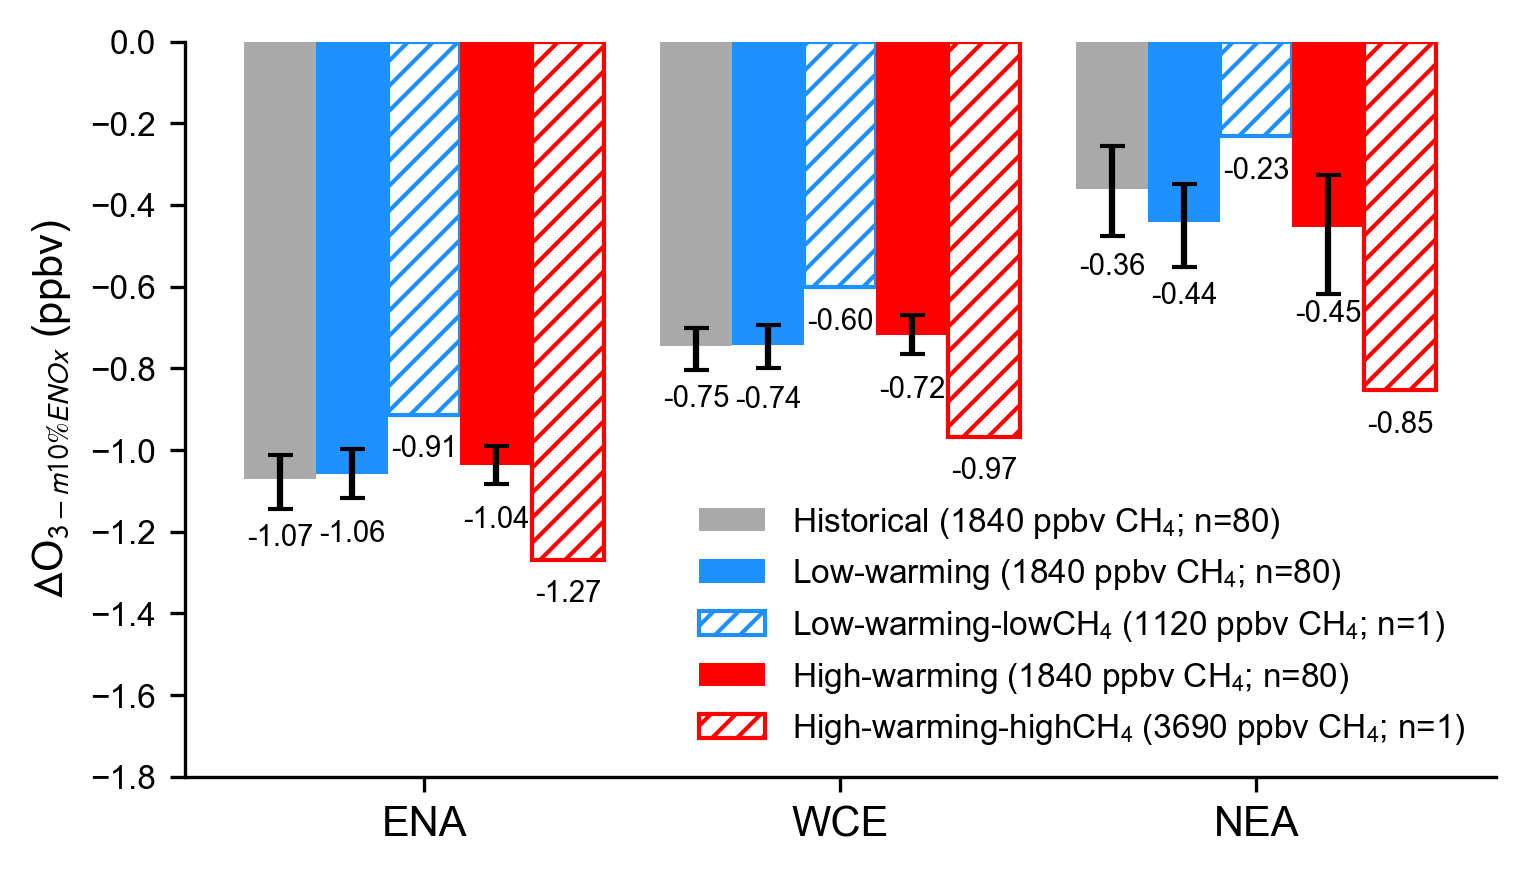

In [9]:
bar_width = 0.45
categories = ['ENA', 'WCE', 'NEA']
x = np.arange(len(categories)) * 2.6  # multiplier >1 spreads out the bar groups

tools.set_matplotlib_font("Arial")
mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})


fig = plt.figure(figsize=(5.33, 2.85), dpi=300)
gs1 = GridSpec(1, 1, top=0.95, bottom=0.09, left=0.15, right=0.97, hspace=0.50, wspace=0.4)
axes = fig.add_subplot(gs1[0, 0])

axes.bar(x - 2*bar_width, ref_mean,         bar_width, yerr=tools.reshape_data(ref_std),      capsize=3, label="Historical (1840 ppbv CH$_4$; n=80)", color="darkgray", lw=0.5)
axes.bar(x - bar_width,   polshort_mean,    bar_width, yerr=tools.reshape_data(polshort_std), capsize=3, label="Low-warming (1840 ppbv CH$_4$; n=80)", color="dodgerblue")
axes.bar(x,               polshortCH4_mean, bar_width, label="Low-warming-lowCH$_4$ (1120 ppbv CH$_4$; n=1)", color="white", hatch='////', edgecolor="dodgerblue")
axes.bar(x + bar_width,   refshort_mean,    bar_width, yerr=tools.reshape_data(refshort_std), capsize=3, label="High-warming (1840 ppbv CH$_4$; n=80)", color="red")
axes.bar(x + 2*bar_width, refshortCH4_mean, bar_width, label="High-warming-highCH$_4$ (3690 ppbv CH$_4$; n=1)", color="white", hatch='////', edgecolor="red")

axes.set_ylabel(r"$\Delta$O$_{3-m10\%ENOx}$ (ppbv)", fontsize=10)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(fontsize=8, frameon=False, loc='lower right')

for i in range(len(categories)):
    # Historical
    y_val = float(ref_mean[i].item()) - float(ref_std[i][1].item()) - 0.05
    axes.text(x[i] - 2*bar_width, y_val, f"{float(ref_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # Low-Warming (multi-member)
    y_val = float(polshort_mean[i].item()) - float(polshort_std[i][1].item()) - 0.05
    axes.text(x[i] - bar_width, y_val, f"{float(polshort_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # Low-Warming (single-member)
    y_val = float(polshortCH4_mean[i].item()) - 0.05
    axes.text(x[i], y_val, f"{float(polshortCH4_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # High-Warming (multi-member)
    y_val = float(refshort_mean[i].item()) - float(refshort_std[i][1].item()) - 0.05
    axes.text(x[i] + bar_width, y_val, f"{float(refshort_mean[i]):.2f}", ha='center', va='top', fontsize=7)

    # High-Warming (single-member)
    y_val = float(refshortCH4_mean[i].item()) - 0.05
    axes.text(x[i] + 2*bar_width, y_val, f"{float(refshortCH4_mean[i]):.2f}", ha='center', va='top', fontsize=7)
             
plt.xticks(x, categories, fontsize=10)
plt.ylim([-1.8, 0])
plt.savefig("FigS11_new.png")